In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from matplotlib_venn import venn2
plt.rcParams['figure.constrained_layout.use'] = True
np.random.seed(seed=0)

from feature_extraction import featureExtractor

In [2]:
data_file = "../data/enron_spam_data.csv"
stop_words_file = "../data/stop_words.csv"

## Exploring the dataset

In [3]:
fe = featureExtractor(data_file=data_file,
                      stop_word_file=stop_words_file,
                      extract_from=['spam'],
                      top_words=1000)
fe.run()
spam_set = set(fe.freq_dict.keys())
print(fe.encoding_dict)

fe = featureExtractor(data_file=data_file,
                      stop_word_file=stop_words_file,
                      extract_from=['ham'],
                      top_words=1000)
fe.run()
ham_set = set(fe.freq_dict.keys())
print(fe.encoding_dict)

{'com': 0, 'company': 1, 'e': 2, 'http': 3, 'email': 4, 'information': 5, 'please': 6, 'statements': 7, 'us': 8, 'may': 9, 'one': 10, 'time': 11, 'www': 12, 'get': 13, 'de': 14, 'business': 15, 'money': 16, 'new': 17, 'within': 18, 'mail': 19, 'price': 20, 'free': 21, 'report': 22, 'click': 23, 'investment': 24, 'account': 25, 'make': 26, 'future': 27, 'message': 28, 'inc': 29, 'securities': 30, 'like': 31, 'forward': 32, 'r': 33, 'stock': 34, 'best': 35, 'address': 36, 'looking': 37, 'order': 38, 'adobe': 39, 'net': 40, 'go': 41, 'use': 42, 'l': 43, 'number': 44, 'need': 45, 'million': 46, 'online': 47, 'want': 48, 'security': 49, 'also': 50, 'news': 51, 'contact': 52, 'site': 53, 'u': 54, 'p': 55, 'software': 56, 'companies': 57, 'could': 58, 'market': 59, 'many': 60, 'products': 61, 'send': 62, 'made': 63, 'gas': 64, 'name': 65, 'b': 66, 'next': 67, 'act': 68, 'see': 69, 'c': 70, 'offer': 71, 'list': 72, 'x': 73, 'today': 74, 'home': 75, 'international': 76, 'day': 77, 'internet': 7

In [4]:
only_spam = spam_set - ham_set
only_ham = ham_set - spam_set
union = ham_set | spam_set
intersect = ham_set - only_ham

print(len(spam_set), len(ham_set), len(only_spam), len(only_ham))

115656 50534 91324 26202


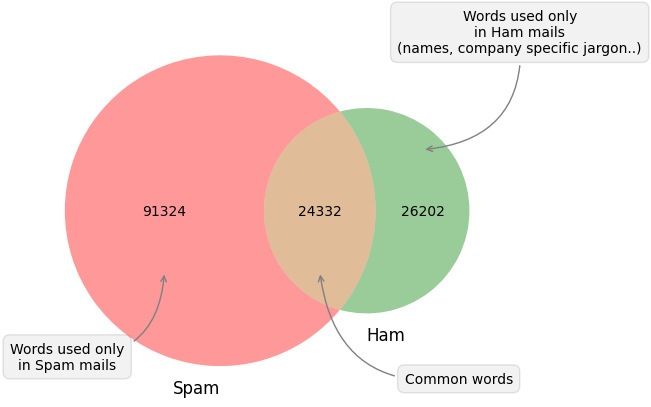

In [5]:
v2 = venn2(subsets = [spam_set, ham_set], set_labels = ('Spam', 'Ham'))

plt.annotate('Words used only\nin Spam mails', xy=v2.get_label_by_id('10').get_position() - np.array([0, 0.2]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.annotate('Words used only\nin Ham mails\n(names, company specific jargon..)', xy=v2.get_label_by_id('01').get_position() + np.array([0.0, 0.2]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5',color='gray'))

plt.annotate('Common words', xy=v2.get_label_by_id('11').get_position() + np.array([0.0, -0.2]), xytext=(+100,-80),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5',color='gray'))

plt.savefig("../outputs/ham_spam_set")

## Split dataset

In [6]:
df = pd.read_csv(data_file)
# remove rows with NaN and reset index
df = df.dropna()
df = df.reset_index()

spam_df = df[df["Spam/Ham"] == 'spam']
ham_df = df[df["Spam/Ham"] == 'ham']

# train test split 0.8/0.2
spam_sz = spam_df.shape[0]
ham_sz = ham_df.shape[0]

split = 0.8
train_spam_pts = np.random.choice(spam_sz, int(split*spam_sz), replace=False)
train_spam_idx = np.zeros(spam_sz).astype(bool)
train_spam_idx[train_spam_pts] = True

train_ham_pts = np.random.choice(ham_sz, int(split*ham_sz), replace=False)
train_ham_idx = np.zeros(ham_sz).astype(bool)
train_ham_idx[train_ham_pts] = True

# create training and testing data frames
# save them
train_df = pd.concat([spam_df.iloc[train_spam_idx],
                      ham_df.iloc[train_ham_idx]])
test_df = pd.concat([spam_df.iloc[~train_spam_idx],
                      ham_df.iloc[~train_ham_idx]])
train_df.to_csv("../data/enron_train.csv", index=False)
test_df.to_csv("../data/enron_test.csv", index=False)

## Encode and prepare data to run Algorithms

In [7]:
train_file = "../data/enron_train.csv"
test_file = "../data/enron_test.csv"

### Encode and save training data frame
- Save the dataframe
- Save the corresponding set of words and their order used for encoding

In [8]:
fe = featureExtractor(data_file=train_file,
                      stop_word_file=stop_words_file,
                      extract_from=['spam', 'ham'],
                      top_words=500)
fe.run()

num_points = fe.df.shape[0]
train_encode = np.zeros((num_points, len(fe.encoding_dict)+1)).astype(int)

for i in range(num_points):
    train_encode[i][:-1] = fe.encode_text(fe.df["Message"][i])
    if fe.df["Spam/Ham"][i] == 'spam':
        train_encode[i][-1] = 1
    else:
        train_encode[i][-1] = -1

# save array
train_encode = pd.DataFrame(train_encode)
train_encode.to_csv("../data/enron_train_encode_f2.csv", index=False, header=False)

# save corresponding encoding set
with open("../data/enron_train_encode_dict_f2.json", 'w') as f: 
    json.dump(fe.encoding_dict, f)


### Save Test data

In [9]:
test_df = pd.read_csv(test_file)
test_num_points = test_df.shape[0]
labels = []

# save to 'test' folder
for i in range(test_num_points):
    if test_df["Spam/Ham"][i] == 'spam':
        labels.append(1)
    else:
        labels.append(0)
        
    with open(f'../test/email{i}.txt', 'w') as f:
            f.write(test_df["Subject"][i])
            f.write('\n\n')
            f.write(test_df["Message"][i])

# save labels
labels = pd.DataFrame(labels)
labels.to_csv('../test/labels.csv', header=None, index=None)